# Imports

In [ ]:
import db_connection as db
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import DataFrame
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, InputLayer
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError
from matplotlib import pyplot as plt

It is important to create a "settings.ini" file that will contain the necessary parameters (database config parameters, in this case) for the "cfg.py" script. The format of this file will be:
<br>
<br>
[settings]<br>
DB_PASS=example_pass<br>
DB_USER=postgres<br>
DB_NAME=postgres<br>
DB_HOST=127.0.0.1<br>
DB_PORT=5432<br>
<br>
This is the configuration that a local postgreSQL database needs in order to create a connection with python 3. Note that this is a standard configuration and details may vary depending on the configuration of your own database.

# Functions definition

## PHASE 1: ETL

First, we need to set the client that will be used to get data from BigQuery. In this case, we created a .json key from our Google Cloud project and downloaded it to use it in our "src/" repository folder:

In [ ]:
# Google Cloud BigQuery client for extracting raw data
client = bigquery.Client()

Next, we will define our 3 steps for data gathering:<br>

- <strong>extract</strong>: step that contains the query which extracts raw information from our chosen dataset.
- <strong>transform</strong>: step that cleans the retrieved data from previous step. In this case, 5 columns that the own code describes.
- <strong>load</strong>: step that loads the clean data in our database. <em>Note</em> that between this step and the previous one we will train our neural network in order to save our prediction.

In [ ]:
def extract():
    query = "SELECT * FROM `housecanary-com.sample.zip_ts` LIMIT 2000"

    query_job = client.query(query)

    return query_job


def transform(data_raw):
    '''
    columns that will be saved (from 'zip_ts' table from dataset ):
        - zip (string): 5 digit postal code
        - msa (string): 5 digit Metropolitan Statistical Area code
        - month (date): timeseries date
        - hpi_value (float): nominal housing price index
        - hpi_real (float): real housing price index after adjusting nominal hpi for inflation as measured by the CPI
    '''

    # Selecting desired columns and saving them in a list for filtering next
    selected_columns = ['zip', 'msa', 'month', 'hpi_value', 'hpi_real']

    # Getting DataFrame from previous query result
    df_clean = data_raw.to_dataframe()

    # Filtering columns given selected columns list
    df_clean: DataFrame = df_clean.loc[:, selected_columns]

    # Converting zip and msa columns to float values, month to datetime
    df_clean['zip'] = df_clean['zip'].astype(float)
    df_clean['msa'] = df_clean['msa'].astype(float)
    df_clean['month'] = pd.to_datetime(df_clean['month'])

    # Cleaning data from NaN values in hpi_value and hpi_real
    df_clean = df_clean[df_clean.hpi_value.notnull()]
    df_clean = df_clean[df_clean.hpi_real.notnull()]

    return df_clean


def load(conn, df):
    # Table and Schema
    table_name = "zip_ts_raw"
    schema_name = "public"
    
    db.insert_rows(df, table_name, schema_name, conn)

## PHASE 2: AI training

In this phase, we will create a tensorflow model that will use the retrieved and cleaned data from previous our ETL phase.

In [ ]:
# Retrieving raw data from Google Cloud Platform dataset (House-canary)
data_raw = extract()

# Transforming raw data into processed data for database
data_processed = transform(data_raw)

In [ ]:
data_processed = data_processed.sort_values(by=['month'])
data_processed

In [ ]:
df_plot = data_processed[['month', 'hpi_value', 'hpi_real']]
df_plot.set_index('month', inplace=True)

df_plot

In [ ]:
df_plot.plot(kind='line', figsize=(14,8))
plt.title('Housing pricing')
plt.ylabel(ylabel='values')
plt.xlabel(xlabel='date')

In [ ]:
#pd.set_option('display.max_rows', 50)
data_processed

In [58]:
# Divide data in features (X) and labels (y)
WINDOW_SIZE = 5

# Here, if I use this commented line instead of the next one, the training loss will be much worse (I suspect it is because they're constants)
#df_as_np_input = data_processed.drop(['month'], axis=1).to_numpy()
df_as_np_input = data_processed.drop(['month', 'zip', 'msa'], axis=1).to_numpy()

df_as_np_output = data_processed[['hpi_value', 'hpi_real']].to_numpy()

X = []
y = []

for i in range(len(df_as_np_input)-WINDOW_SIZE):
    row = [a for a in df_as_np_input[i:i+5]]
    X.append(row)

    label = df_as_np_output[i+5]
    y.append(label)

X = np.array(X)
y = np.array(y)

X.shape, y.shape

((1687, 5, 4), (1687, 2))

In [59]:
### Divide data in test and train sets

# Training data
X_train, y_train = X[:1200], y[:1200]

# Validation data
X_val, y_val = X[1200:1400], y[1200:1400]

# Test data
X_test, y_test = X[1400:], y[1400:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1200, 5, 4), (1200, 2), (200, 5, 4), (200, 2), (287, 5, 4), (287, 2))

In [60]:
model_gru = Sequential()
model_gru.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(64))
model_gru.add(Dense(8, activation='relu'))
model_gru.add(Dense(2, activation='linear'))
#model_gru.add(Dense(1, activation='linear'))

# Define neural network architecture
model = Sequential([
    InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])), # Input shape as parameter
    LSTM(64),
    Dense(8, activation='relu'),
    Dense(2, activation='linear')  # 2 output neurons to predict 2 columns
    #Dense(1, activation='linear')  # 2 output neurons to predict 2 columns
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=[RootMeanSquaredError()])
model_gru.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=[RootMeanSquaredError()])

In [61]:
# Train model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
history_gru = model_gru.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
38/38 [==============================] - 1s 8ms/step - loss: 6941.9360 - root_mean_squared_error: 83.3183 - val_loss: 14187.9404 - val_root_mean_squared_error: 119.1131
Epoch 2/30
38/38 [==============================] - 0s 2ms/step - loss: 6916.1313 - root_mean_squared_error: 83.1633 - val_loss: 14147.1113 - val_root_mean_squared_error: 118.9416
Epoch 3/30
38/38 [==============================] - 0s 2ms/step - loss: 6887.2876 - root_mean_squared_error: 82.9897 - val_loss: 14101.8096 - val_root_mean_squared_error: 118.7510
Epoch 4/30
38/38 [==============================] - 0s 2ms/step - loss: 6855.0356 - root_mean_squared_error: 82.7951 - val_loss: 14049.9717 - val_root_mean_squared_error: 118.5326
Epoch 5/30
38/38 [==============================] - 0s 2ms/step - loss: 6818.2988 - root_mean_squared_error: 82.5730 - val_loss: 13991.9238 - val_root_mean_squared_error: 118.2875
Epoch 6/30
38/38 [==============================] - 0s 2ms/step - loss: 6777.9785 - root_mean_square

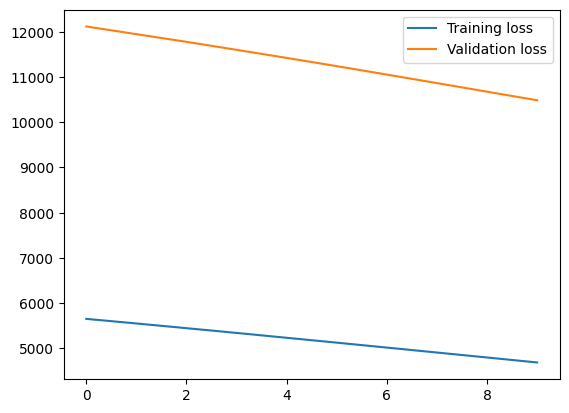

In [62]:
plt.plot(history.history['loss'][20:30], label='Training loss')
plt.plot(history.history['val_loss'][20:30], label='Validation loss')
plt.legend()

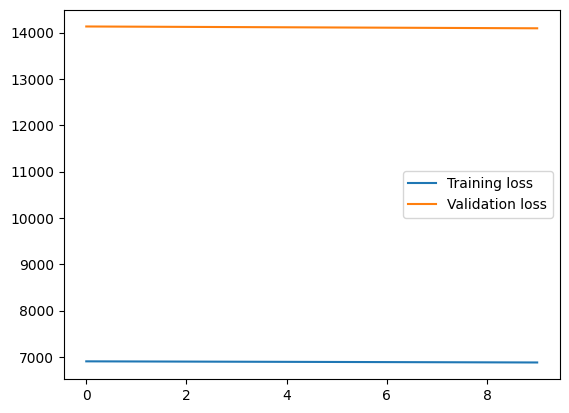

In [63]:
plt.plot(history_gru.history['loss'][20:30], label='Training loss')
plt.plot(history_gru.history['val_loss'][20:30], label='Validation loss')
plt.legend()

In [64]:
train_predictions1 = model.predict(X_train)
train_predictions2 = model_gru.predict(X_train)
train_results = pd.DataFrame(data={'hpi_value_prediction_LSTM': train_predictions1[:, 0],
                                   'hpi_real_prediction_LSTM': train_predictions1[:, 1],
                                   'hpi_value_prediction_GRU': train_predictions2[:, 0],
                                   'hpi_real_prediction_GRU': train_predictions2[:, 1],
                                   'hpi_value': y_train[:, 0],
                                   'hpi_real': y_train[:, 1]})
train_results

38/38 [==============================] - 0s 732us/step


,hpi_value_prediction_LSTM,hpi_real_prediction_LSTM,hpi_value_prediction_GRU,hpi_real_prediction_GRU,hpi_value,hpi_real
0,13.996191,22.154692,0.564238,0.567243,13.768903,45.531258
1,13.996191,22.154692,0.564238,0.567243,12.701623,41.843461
2,13.996191,22.154692,0.564238,0.567243,8.042733,26.495494
3,13.996191,22.154692,0.564238,0.567243,13.820352,45.528933
4,13.996191,22.154692,0.564238,0.567243,13.928677,45.799377
...,...,...,...,...,...,...
1195,13.996191,22.154692,0.564238,0.567243,154.218645,123.821410
1196,13.996191,22.154692,0.564238,0.567243,138.114581,110.891535
1197,13.996191,22.154692,0.564238,0.567243,131.762084,105.791145
1198,13.996191,22.154692,0.564238,0.567243,136.477662,108.800269


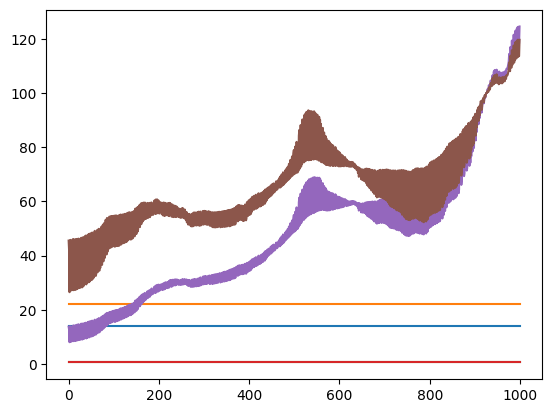

In [65]:
plt.plot(train_results['hpi_value_prediction_LSTM'][:1000])
plt.plot(train_results['hpi_real_prediction_LSTM'][:1000])
plt.plot(train_results['hpi_value_prediction_GRU'][:1000])
plt.plot(train_results['hpi_real_prediction_GRU'][:1000])
plt.plot(train_results['hpi_value'][:1000])
plt.plot(train_results['hpi_real'][:1000])

In [48]:
train_predictions1 = model.predict(X_train)
train_predictions2 = model_gru.predict(X_train)
train_results = pd.DataFrame(data={'hpi_value_prediction_LSTM': train_predictions1[:, 0],
                                   'hpi_value_prediction_GRU': train_predictions2[:, 0],
                                   'hpi_value': y_train[:, 0]})
train_results

38/38 [==============================] - 0s 732us/step


,hpi_value_prediction_LSTM,hpi_value_prediction_GRU,hpi_value
0,13.092822,11.672248,13.768903
1,13.159951,12.291338,12.701623
2,13.250493,11.953387,8.042733
3,13.311749,15.168269,13.820352
4,13.560107,13.269721,13.928677
...,...,...,...
1195,73.633949,134.978516,154.218645
1196,73.634132,135.042221,138.114581
1197,73.634071,134.979767,131.762084
1198,73.633644,134.883102,136.477662


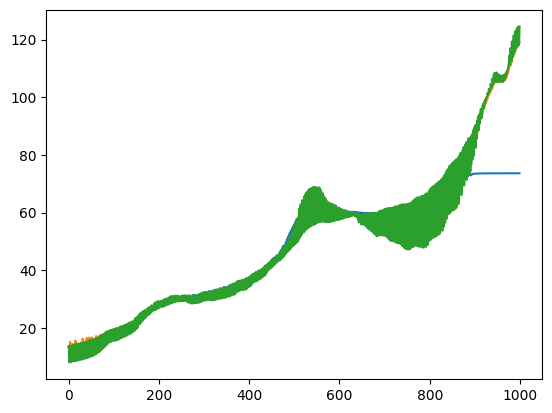

In [49]:
plt.plot(train_results['hpi_value_prediction_LSTM'][:1000])
plt.plot(train_results['hpi_value_prediction_GRU'][:1000])
plt.plot(train_results['hpi_value'][:1000])

In [ ]:
dates = data_processed['month']
dates

In [ ]:
# Get training dataframe
training_df = data_processed.drop(['month'], axis=1)
training_df

In [ ]:
scalar = StandardScaler()
scalar = scalar.fit(training_df)
training_df_scaled = scalar.transform(training_df)
training_df_scaled

In [ ]:
trainX = []
trainY = []

n_past = 20 # 20 values considered to predict next values
n_fut = 100 # 100 values to be predicted based on the 20 previous values

# Adding values to x and y lists
for i in range(n_past, len(training_df_scaled)-n_fut+1):
    trainX.append(training_df_scaled[i-n_past:i, 0:training_df_scaled.shape[1]])
    trainY.append(training_df_scaled[i+n_fut-1:i+n_fut, 2:4])

# Converting into numpy arrays
trainX, trainY = np.array(trainX), np.array(trainY)

print(f'trainX shape: {trainX.shape}')
print(f'trainY shape: {trainY.shape}')

In [ ]:
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
history = model.fit(trainX, trainY, epochs=30, batch_size=25, validation_split=0.2, verbose=1)

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
test_predictions1 = model.predict(X_test)

In [ ]:
X_test[1][2:4]

In [ ]:
X_test_list = []
for i in range(len(X_test)):
    X_test_list.append(X_test[i][2:4])
    

test_predictions_df1 = pd.DataFrame({'X_test':list(X_test_list), 
                                    'LSTM Prediction':list(test_predictions1)})

In [ ]:
test_predictions_df1